In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import mfcc
%matplotlib inline

In [10]:
import dataloader
import random
audio, sample_rate = random.choice(random.choice(list(dataloader.get_dataset(1,1).items()))[1]), dataloader.UNIFORM_SAMPLE_RATE
fft_size = int(30 / 1000 * sample_rate)

(65, 120)
1.7995349755251694e-05 26.085919310588263


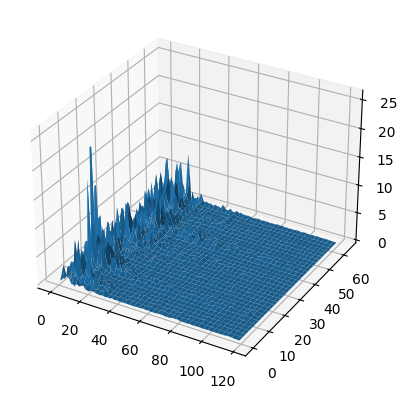

(65, 16)
-1.0 1.0


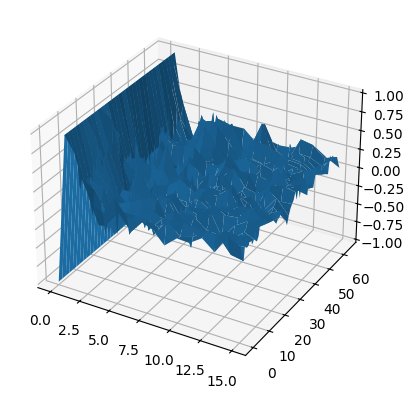

In [11]:
spectrum = np.abs(mfcc.spectrogram(audio, fft_size = fft_size, sample_rate = sample_rate))
spectrum_mel = mfcc.mfcc_spectrogram(audio, fft_size = fft_size, sample_rate = sample_rate, mel_filters = 16, dct_filters = 16)

# spectrum_mel = spectrum_mel[1:,:]
m,s = np.mean(spectrum_mel), np.std(spectrum_mel)
spectrum_mel -= m
spectrum_mel /= s
spectrum_mel = np.maximum(spectrum_mel, -1)
spectrum_mel = np.minimum(spectrum_mel, +1)

def plot3d(spectrum):
    assert len(spectrum.shape) == 2
    fig = plt.figure()
    p = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(range(spectrum.shape[1]), range(spectrum.shape[0]))
    p.plot_surface(x, y, spectrum)
    plt.show()
def show_info(trans):
    print(trans.shape)
    print(np.min(trans), np.max(trans))
    plot3d(trans)

show_info(spectrum)
show_info(spectrum_mel.T)


# plt.figure(figsize = (5, 5))
# plt.plot(np.linspace(0, len(audio) / sample_rate, num = len(audio)), audio)
# plt.imshow(trans, aspect = 'auto', origin = 'lower')